In [1]:
# langchain reads the OPENAI_API_KEY environment variable.
import os

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
assert OPENAI_API_KEY and len(OPENAI_API_KEY) > 32

In [2]:
# these functions are the basic steps for
# generating a personalized listing.
from homematch_functions import load_documents
from homematch_functions import load_vector_db
from homematch_functions import build_similar_documents
from homematch_functions import filter_similar_documents
from homematch_functions import personalize_listing

In [3]:
# load documents from the listings.json file,
# and create a lookup table for the original JSON source.
documents = load_documents()
documents_by_uuid: dict[str, str] = {
    doc.metadata["record_uuid"]:doc.page_content for doc in documents
}
vector_db = load_vector_db(documents)
print(f"{len(documents)=}")

load_vector_db: existing vector database


/Users/jason/Projects/2025-06-personalized-real-estate-agent/homematch_functions.py:46: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_db = Chroma(


len(documents)=20


In [4]:
# these are the questions that a customer will answer.
# order and number of the answers must match the questions.
questions = [
    "How big do you want your house to be?",
    "What are 3 most important things for you in choosing this property?", 
    "Which amenities would you like?", 
    "Which transportation options are important to you?",
    "How urban do you want your neighborhood to be?",
]

In [17]:
answers_1 = [
    "A comfortable three-bedroom house with a spacious kitchen and a cozy living room.",
    "A quiet neighborhood, good local schools, and convenient shopping options.",
    "A backyard for gardening, a two-car garage, and a modern, energy-efficient heating system.",
    "Easy access to a reliable bus line, proximity to a major highway, and bike-friendly roads.",
    "A balance between suburban tranquility and access to urban amenities like restaurants and theaters.",
]

answers_2 = [
    "A comfortable condominum with at least 2 bedrooms.",
    "Access to public transportation, bike lanes, and convenient shopping.",
    "A modern kitchen and appliances.",
    "Easy access to a reliable bus line and bike-friendly roads.",
    "I like urban amenities like restaurants, theaters, and museums.",
]

answers_3 = [
    "A luxurious home with many bedrooms and bathrooms.",
    "Large rooms and windows, backyard, multiple car garage.",
    "A modern kitchen and appliances.",
    "Easy access to shopping and a highway to downtown.",
    "I want a home in the suburbs.",
]

# set the predefined answers here!
answers = answers_3

answers

['A luxurious home with many bedrooms and bathrooms.',
 'Large rooms and windows, backyard, multiple car garage.',
 'A modern kitchen and appliances.',
 'Easy access to shopping and a highway to downtown.',
 'I want a home in the suburbs.']

In [18]:
# build_similar_documents returns a dictionary of record_uuid to a set 
# of similar answer indexes. the parameters used are the minimum document
# count to match (the "k" value), and the minimum score required.
similar_documents_ids = build_similar_documents(vector_db, answers, minimum_count=5, minimum_score=0.1)
similar_documents_ids

{'c34f1cde-5a9c-4b5f-bcde-9e8b7f2e9101': {0, 1, 4},
 '1a5d6c7e-4b8e-4569-bd53-9c4d21a5e8f3': {0, 1, 4},
 'd4e5f6g7-8h9i-0a1b-2c3d-e4f5g6h7i8j9': {0},
 'a9e3f7b2-3c5e-4d77-8a2d-1b6c6d6d6b7c': {0},
 'a3b2c3d4-e5f6-7890-abcd-ef1234567892': {0, 1},
 'c3d4e5f6-7g8h-9i0a-1b2c-d3e4f5g6h7i8': {1, 4},
 'a12f7b7e-8f4a-4bce-b2b8-1a8a5e6e1234': {1, 4},
 'a1b2c3d4-e5f6-7890-abcd-ef1234567890': {2},
 'c4d6e2f8-a2d4-4e6f-8f1e-3d8f2e3c9f2b': {2},
 'd1f29484-8b3e-4bfa-bd65-b4a3e9075b5b': {2},
 '56b7f6cd-7ab5-4d0f-a6f6-8e8f95e5f6e2': {2},
 'f1a7f2c1-8e5d-4e4b-b91c-3b69d5d3d2a6': {2},
 '8cb857d3-c398-4a6f-9b49-3c90b0c4f8d1': {4}}

In [19]:
# filter_similar_documents returns the same structure filtered
# down based on answer match count. the parameter `3` here is
# reasonable since it means the majority of answers as similar
# to the document.
filtered_documents_ids = filter_similar_documents(similar_documents_ids, minimum_matches=3)
filtered_documents_ids

{'c34f1cde-5a9c-4b5f-bcde-9e8b7f2e9101': {0, 1, 4},
 '1a5d6c7e-4b8e-4569-bd53-9c4d21a5e8f3': {0, 1, 4}}

In [20]:
# the personalize_listing function uses ChatOpanAI to create the
# personalized description.
personalized_listings = {}
for record_uuid, answer_indexes in filtered_documents_ids.items():
    listing = documents_by_uuid[record_uuid]
    filtered_answers = [answers_1[i] for i in answer_indexes]
    result = personalize_listing(listing, filtered_answers)
    personalized_listings[record_uuid] = {
        "record_uuid": record_uuid,
        "filtered_answers": filtered_answers,
        "description": result,
    }
print(f"{len(personalized_listings)=}")

len(personalized_listings)=2



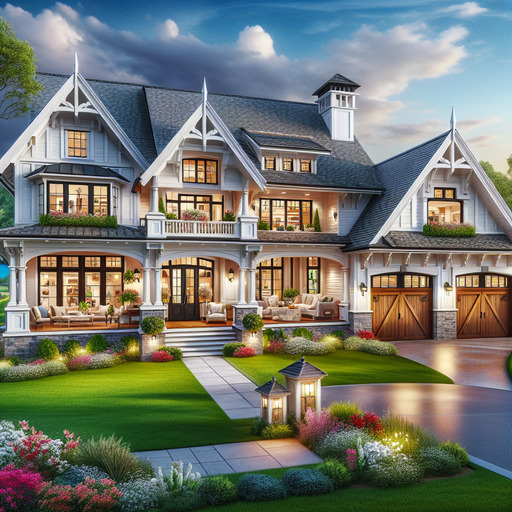
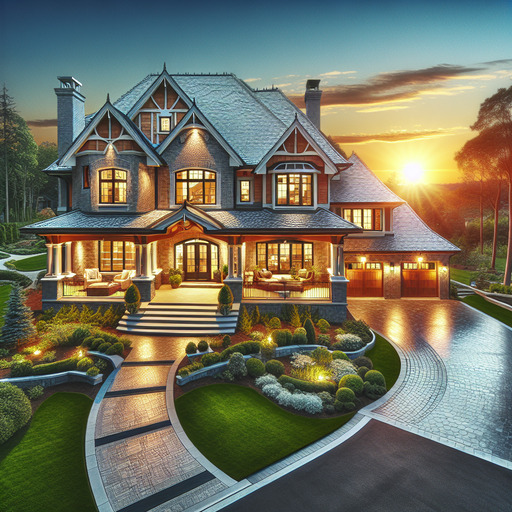

In [21]:
from IPython.display import HTML
from homematch_index_html import get_data_urls

images = get_data_urls(list(personalized_listings.keys()))

blocks = []

lines = []
for index, question in enumerate(questions):
    answer = answers[index]
    lines.append(f"{question} <b>{answer}</b><br>")
    
blocks.append(f"""<div style="border: 2px solid gray; padding:0.5em;">{''.join(lines)}""")

for record_uuid, listing in personalized_listings.items():
    description = listing["description"].replace("\n", "<br>")
    blocks.append(f"""
        <div style="border: 2px dotted gray; margin:1em; padding:1em; min-height:300px;">
            {record_uuid}<br>
            <img src="{images[record_uuid]}" width="256" style="float:left; margin:1em;"/>
            {description}
        </div>
    """)

blocks.append("</div>")

HTML('\n'.join(blocks))

In [22]:
# append the html to a file for reference.
with open("listings.html", "a") as file:
    file.write('\n'.join(blocks))
True

True